In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
from keras_preprocessing import image

2024-08-11 16:04:51.474802: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-11 16:04:51.534063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-11 16:04:51.591452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 16:04:51.645878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 16:04:51.660808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 16:04:51.748104: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def read_data(dir, data):
    images1 = [] 
    images2 = [] 
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

In [3]:
train_dir = 'sign_data/train'
train_csv = 'sign_data/train_data.csv'
df_train = pd.read_csv(train_csv, header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)

In [5]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


sign_data/train/068/09_068.png


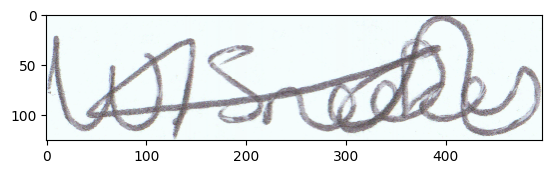

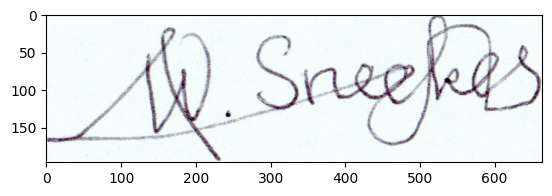

In [6]:
img_original = plt.imread('sign_data/train/'+img_org)
img_forged = plt.imread('sign_data/train/'+img_frg)

print('sign_data/train/'+img_org)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

# Simple Siamese Network

In [24]:
def initialize_base_network(input_shape):
    clf = Sequential()
    clf.add(Convolution2D(64, (3,3),input_shape=input_shape))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Convolution2D(32, (3,3)))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Flatten())
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    return clf
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [8]:
input_dim = (100, 100, 1)
base_network = initialize_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

/home/sahil/anaconda3/envs/sign2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723372572.799383    6659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 16:06:12.800015: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libr

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │  2,194,272 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │          4 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,194,276 (8.37 MB)

 Trainable params: 2,194,276 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=40)

Epoch 1/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 170s 331ms/step - accuracy: 0.4458 - loss: 0.6093 - val_accuracy: 0.5036 - val_loss: 0.5034
Epoch 2/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 167s 330ms/step - accuracy: 0.8092 - loss: 0.4162 - val_accuracy: 0.5382 - val_loss: 0.5257
Epoch 3/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 165s 326ms/step - accuracy: 0.9337 - loss: 0.3766 - val_accuracy: 0.5859 - val_loss: 0.5197
Epoch 4/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 164s 323ms/step - accuracy: 0.9759 - loss: 0.3495 - val_accuracy: 0.6171 - val_loss: 0.5192
Epoch 5/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 168s 332ms/step - accuracy: 0.9899 - loss: 0.3261 - val_accuracy: 0.6507 - val_loss: 0.5075
Epoch 6/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 170s 334ms/step - accuracy: 0.9935 - loss: 0.3064 - val_accuracy: 0.6800 - val_loss: 0.4943
Epoch 7/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 171s 337ms/step - accuracy: 0.9978 - loss: 0.2876 - val_accuracy: 0.6952 - val_loss: 0.4858
Epoch 8/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 172s 338ms/step - accuracy: 0.9986 -

In [15]:
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]
img_original = 'sign_data/train/'+img_org
img_forged = 'sign_data/train/'+img_frg

x = image.load_img(img_original, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img(img_forged, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[2.3216835e-08 1.0000000e+00]]
1


In [16]:
if y_pred==1:
  print('Forged')
else:
  print('Real')

Forged


In [11]:
model.save('savedModel/my_model.h5')

In [12]:
model.save('savedModel/my_model_keras.keras')

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('savedModel/mobile_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkj844z94/assets


INFO:tensorflow:Assets written to: /tmp/tmpkj844z94/assets


Saved artifact at '/tmp/tmpkj844z94'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name='keras_tensor_46'), TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name='keras_tensor_47')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  126517697727376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697732752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697731984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697734864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697733712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697735440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697735632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697736784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126517697735056: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1723386132.529943    6659 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723386132.529986    6659 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-11 19:52:12.530499: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkj844z94
2024-08-11 19:52:12.531949: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-11 19:52:12.531971: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkj844z94
2024-08-11 19:52:12.539205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-08-11 19:52:12.540655: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-11 19:52:12.592049: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkj844z94
2024-08-11 19:52:12.606600: I tensorflow/cc/saved_model/loader.cc

In [21]:
# import keras
from tensorflow.keras.models import load_model

In [27]:
loaded_model = load_model("savedModel/my_model_keras.keras", custom_objects={'euclidean_distance': euclidean_distance, "eucl_dist_output_shape":eucl_dist_output_shape})


/home/sahil/anaconda3/envs/sign2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
img_original = 'sign_data/test/049/01_049.png'
img_forged = 'sign_data/test/049/07_049.png'

x = image.load_img(img_original, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img(img_forged, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = loaded_model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.9467396  0.05326044]]


In [32]:
if y_pred==1:
  print('Forged')
else:
  print('Real')

Real
